In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import shutil
import torch.distributed as dist
import math
from PIL import Image
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from torch.hub import load_state_dict_from_url
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import BatchSampler
from collections.abc import Mapping, Sequence

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
train_path_path= f"{os.getcwd()}/data/split_train/train"
test_path_path= f"{os.getcwd()}/data/split_train/val"

In [3]:
batch_size=256
num_gpus=4
num_workers=8
lr=0.001

In [4]:
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                     std=[0.267, 0.256, 0.276])

In [5]:
dataset = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(70),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (19):
    aug_data = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(70),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    dataset=torch.utils.data.ConcatDataset([dataset,aug_data])
valset = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(70),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (19):
    aug_data = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(70),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    valset=torch.utils.data.ConcatDataset([valset,aug_data])

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

In [6]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [7]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [8]:
class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def _resnext(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [9]:
def Model(pretrained: bool = False, progress: bool = True, **kwargs):
    
    kwargs['groups'] = 8
    kwargs['width_per_group'] = 4
    return _resnext('resnext', Bottleneck, [3, 6, 3], pretrained, progress, **kwargs)


In [10]:
model = Model()
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()

In [11]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [12]:
from torchsummary import summary
summary(model,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 32, 24, 24]           2,048
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
            Conv2d-8           [-1, 32, 24, 24]           1,152
       BatchNorm2d-9           [-1, 32, 24, 24]              64
             ReLU-10           [-1, 32, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]           8,192
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)

In [14]:
saving_path="/home/jupyter-deeplearning/res_model"
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=500
model_char="2.0"
model_name=""
patience=10
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    scheduler.step()
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name=saving_path+"Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/11/15 03:27:10
epoch: 1/500 | trn loss: 1.9141 | val loss: 1.7262 | val accuracy: 35.5419% 

2020/11/15 03:27:50
epoch: 2/500 | trn loss: 1.6309 | val loss: 1.5614 | val accuracy: 42.9337% 

2020/11/15 03:28:29
epoch: 3/500 | trn loss: 1.4576 | val loss: 1.4410 | val accuracy: 47.8966% 

2020/11/15 03:29:09
epoch: 4/500 | trn loss: 1.3283 | val loss: 1.4047 | val accuracy: 50.0952% 

2020/11/15 03:29:48
epoch: 5/500 | trn loss: 1.2243 | val loss: 1.3194 | val accuracy: 52.4890% 

2020/11/15 03:30:28
epoch: 6/500 | trn loss: 1.1168 | val loss: 1.2567 | val accuracy: 55.5639% 

2020/11/15 03:31:07
epoch: 7/500 | trn loss: 1.0548 | val loss: 1.2447 | val accuracy: 56.2500% 

2020/11/15 03:31:47
epoch: 8/500 | trn loss: 0.9849 | val loss: 1.2019 | val accuracy: 58.1180% 

2020/11/15 03:32:25
epoch: 9/500 | trn loss: 0.9296 | val loss: 1.1777 | val accuracy: 58.9794% 

2020/11/15 03:33:05
epoch: 10/500 | trn loss: 0.8665 | val loss: 1.1943 | val accuracy: 58.8792% 

2020/11/15 03:33:45

2020/11/15 04:19:00
epoch: 80/500 | trn loss: 0.2615 | val loss: 1.2606 | val accuracy: 66.6516% 

2020/11/15 04:19:39
epoch: 81/500 | trn loss: 0.2611 | val loss: 1.2306 | val accuracy: 66.7668% 

2020/11/15 04:20:18
epoch: 82/500 | trn loss: 0.2592 | val loss: 1.2823 | val accuracy: 66.0306% 

2020/11/15 04:20:58
epoch: 83/500 | trn loss: 0.2564 | val loss: 1.3081 | val accuracy: 65.6851% 

2020/11/15 04:21:37
epoch: 84/500 | trn loss: 0.2539 | val loss: 1.2225 | val accuracy: 67.9537% 

2020/11/15 04:22:16
epoch: 85/500 | trn loss: 0.2508 | val loss: 1.3456 | val accuracy: 65.5399% 

2020/11/15 04:22:55
epoch: 86/500 | trn loss: 0.2558 | val loss: 1.3145 | val accuracy: 65.5699% 

2020/11/15 04:23:35
epoch: 87/500 | trn loss: 0.2482 | val loss: 1.2758 | val accuracy: 66.1809% 

2020/11/15 04:24:14
epoch: 88/500 | trn loss: 0.2533 | val loss: 1.2285 | val accuracy: 66.7518% 

2020/11/15 04:24:54
epoch: 89/500 | trn loss: 0.2466 | val loss: 1.2981 | val accuracy: 66.1909% 

2020/11/15

2020/11/15 05:13:00
epoch: 163/500 | trn loss: 0.0845 | val loss: 1.3439 | val accuracy: 68.9754% 

2020/11/15 05:13:38
epoch: 164/500 | trn loss: 0.0839 | val loss: 1.3015 | val accuracy: 70.0871% 

2020/11/15 05:14:17
epoch: 165/500 | trn loss: 0.0879 | val loss: 1.3487 | val accuracy: 68.8752% 

2020/11/15 05:14:56
epoch: 166/500 | trn loss: 0.0850 | val loss: 1.3470 | val accuracy: 68.9103% 

2020/11/15 05:15:34
epoch: 167/500 | trn loss: 0.0838 | val loss: 1.3284 | val accuracy: 69.5613% 

2020/11/15 05:16:13
epoch: 168/500 | trn loss: 0.0820 | val loss: 1.3126 | val accuracy: 69.4712% 

2020/11/15 05:16:52
epoch: 169/500 | trn loss: 0.0816 | val loss: 1.3295 | val accuracy: 69.1206% 

2020/11/15 05:17:31
epoch: 170/500 | trn loss: 0.0855 | val loss: 1.3066 | val accuracy: 69.5012% 

2020/11/15 05:18:09
epoch: 171/500 | trn loss: 0.0853 | val loss: 1.3233 | val accuracy: 69.1106% 

2020/11/15 05:18:48
epoch: 172/500 | trn loss: 0.0837 | val loss: 1.3112 | val accuracy: 69.2608% 



2020/11/15 06:05:49
epoch: 245/500 | trn loss: 0.0613 | val loss: 1.3287 | val accuracy: 69.8718% 

2020/11/15 06:06:28
epoch: 246/500 | trn loss: 0.0588 | val loss: 1.3359 | val accuracy: 69.4411% 

2020/11/15 06:07:06
epoch: 247/500 | trn loss: 0.0593 | val loss: 1.3252 | val accuracy: 70.0771% 

2020/11/15 06:07:45
epoch: 248/500 | trn loss: 0.0581 | val loss: 1.3302 | val accuracy: 69.6665% 

2020/11/15 06:08:24
epoch: 249/500 | trn loss: 0.0598 | val loss: 1.3310 | val accuracy: 70.0471% 

2020/11/15 06:09:03
epoch: 250/500 | trn loss: 0.0595 | val loss: 1.3541 | val accuracy: 69.4311% 

2020/11/15 06:09:42
epoch: 251/500 | trn loss: 0.0569 | val loss: 1.3362 | val accuracy: 69.7817% 

2020/11/15 06:10:20
epoch: 252/500 | trn loss: 0.0593 | val loss: 1.3380 | val accuracy: 69.5112% 

2020/11/15 06:10:59
epoch: 253/500 | trn loss: 0.0579 | val loss: 1.3306 | val accuracy: 69.8017% 

2020/11/15 06:11:38
epoch: 254/500 | trn loss: 0.0586 | val loss: 1.3455 | val accuracy: 69.7917% 



2020/11/15 06:58:40
epoch: 327/500 | trn loss: 0.0532 | val loss: 1.3264 | val accuracy: 69.8818% 

2020/11/15 06:59:19
epoch: 328/500 | trn loss: 0.0540 | val loss: 1.3593 | val accuracy: 69.6665% 

2020/11/15 06:59:58
epoch: 329/500 | trn loss: 0.0560 | val loss: 1.3672 | val accuracy: 69.2658% 

2020/11/15 07:00:36
epoch: 330/500 | trn loss: 0.0537 | val loss: 1.3400 | val accuracy: 69.9269% 

2020/11/15 07:01:15
epoch: 331/500 | trn loss: 0.0548 | val loss: 1.3143 | val accuracy: 69.9469% 

2020/11/15 07:01:54
epoch: 332/500 | trn loss: 0.0553 | val loss: 1.3428 | val accuracy: 69.5964% 

2020/11/15 07:02:32
epoch: 333/500 | trn loss: 0.0562 | val loss: 1.3534 | val accuracy: 69.7616% 

2020/11/15 07:03:11
epoch: 334/500 | trn loss: 0.0547 | val loss: 1.3561 | val accuracy: 69.5363% 

2020/11/15 07:03:50
epoch: 335/500 | trn loss: 0.0546 | val loss: 1.3583 | val accuracy: 69.5413% 

2020/11/15 07:04:28
epoch: 336/500 | trn loss: 0.0547 | val loss: 1.3322 | val accuracy: 69.6715% 



2020/11/15 07:51:36
epoch: 409/500 | trn loss: 0.0541 | val loss: 1.3456 | val accuracy: 69.3409% 

2020/11/15 07:52:14
epoch: 410/500 | trn loss: 0.0541 | val loss: 1.3407 | val accuracy: 69.6865% 

2020/11/15 07:52:53
epoch: 411/500 | trn loss: 0.0551 | val loss: 1.3297 | val accuracy: 69.9069% 

2020/11/15 07:53:32
epoch: 412/500 | trn loss: 0.0546 | val loss: 1.3375 | val accuracy: 69.8818% 

2020/11/15 07:54:10
epoch: 413/500 | trn loss: 0.0548 | val loss: 1.3379 | val accuracy: 69.7266% 

2020/11/15 07:54:49
epoch: 414/500 | trn loss: 0.0547 | val loss: 1.3410 | val accuracy: 70.2324% 

2020/11/15 07:55:28
epoch: 415/500 | trn loss: 0.0545 | val loss: 1.3267 | val accuracy: 69.5212% 

2020/11/15 07:56:06
epoch: 416/500 | trn loss: 0.0528 | val loss: 1.3437 | val accuracy: 69.6264% 

2020/11/15 07:56:45
epoch: 417/500 | trn loss: 0.0551 | val loss: 1.3497 | val accuracy: 69.2308% 

2020/11/15 07:57:23
epoch: 418/500 | trn loss: 0.0531 | val loss: 1.3651 | val accuracy: 69.3610% 



2020/11/15 08:44:19
epoch: 491/500 | trn loss: 0.0548 | val loss: 1.3641 | val accuracy: 69.7316% 

2020/11/15 08:44:58
epoch: 492/500 | trn loss: 0.0551 | val loss: 1.3324 | val accuracy: 69.5413% 

2020/11/15 08:45:36
epoch: 493/500 | trn loss: 0.0550 | val loss: 1.3317 | val accuracy: 70.1072% 

2020/11/15 08:46:15
epoch: 494/500 | trn loss: 0.0551 | val loss: 1.3239 | val accuracy: 70.0421% 

2020/11/15 08:46:53
epoch: 495/500 | trn loss: 0.0545 | val loss: 1.3274 | val accuracy: 70.1122% 

2020/11/15 08:47:31
epoch: 496/500 | trn loss: 0.0557 | val loss: 1.3258 | val accuracy: 69.7216% 

2020/11/15 08:48:09
epoch: 497/500 | trn loss: 0.0538 | val loss: 1.3401 | val accuracy: 69.7366% 

2020/11/15 08:48:47
epoch: 498/500 | trn loss: 0.0526 | val loss: 1.3765 | val accuracy: 69.2358% 

2020/11/15 08:49:26
epoch: 499/500 | trn loss: 0.0545 | val loss: 1.3261 | val accuracy: 70.0571% 

2020/11/15 08:50:04
epoch: 500/500 | trn loss: 0.0555 | val loss: 1.3500 | val accuracy: 69.5513% 



In [15]:
dataset = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize(120),    
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (19):
    aug_data = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize(120),    
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    dataset=torch.utils.data.ConcatDataset([dataset,aug_data])
valset = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize(120),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (19):
    aug_data = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize(120),    
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    valset=torch.utils.data.ConcatDataset([valset,aug_data])

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50)

In [17]:
#fine tuning

total_epoch=200
model_char="2.0"
model_name=""
patience=10
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    scheduler.step()
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name="Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/11/15 08:51:39
epoch: 1/200 | trn loss: 0.0274 | val loss: 1.0271 | val accuracy: 74.9199% 

2020/11/15 08:53:12
epoch: 2/200 | trn loss: 0.0307 | val loss: 0.9750 | val accuracy: 75.8063% 

2020/11/15 08:54:45
epoch: 3/200 | trn loss: 0.0235 | val loss: 1.0359 | val accuracy: 76.1168% 

2020/11/15 08:56:18
epoch: 4/200 | trn loss: 0.0194 | val loss: 1.0309 | val accuracy: 76.5725% 

2020/11/15 08:57:52
epoch: 5/200 | trn loss: 0.0316 | val loss: 0.9898 | val accuracy: 75.9665% 

2020/11/15 08:59:25
epoch: 6/200 | trn loss: 0.0193 | val loss: 1.1114 | val accuracy: 74.8648% 

2020/11/15 09:00:59
epoch: 7/200 | trn loss: 0.0284 | val loss: 1.0172 | val accuracy: 76.8179% 

2020/11/15 09:02:33
epoch: 8/200 | trn loss: 0.0130 | val loss: 1.0465 | val accuracy: 76.1418% 

2020/11/15 09:04:07
epoch: 9/200 | trn loss: 0.0320 | val loss: 1.1316 | val accuracy: 74.7196% 

2020/11/15 09:05:40
epoch: 10/200 | trn loss: 0.0171 | val loss: 1.0559 | val accuracy: 76.8279% 

2020/11/15 09:07:14

2020/11/15 10:48:35
epoch: 76/200 | trn loss: 0.0009 | val loss: 0.8091 | val accuracy: 78.2953% 

2020/11/15 10:50:08
epoch: 77/200 | trn loss: 0.0011 | val loss: 0.8347 | val accuracy: 77.6693% 

2020/11/15 10:51:42
epoch: 78/200 | trn loss: 0.0015 | val loss: 0.7977 | val accuracy: 78.9563% 

2020/11/15 10:53:15
epoch: 79/200 | trn loss: 0.0007 | val loss: 0.7789 | val accuracy: 78.9914% 

Model replaced and saved as  Custom_model_2.0_0.779
2020/11/15 10:54:48
epoch: 80/200 | trn loss: 0.0007 | val loss: 0.7772 | val accuracy: 79.0665% 

Model replaced and saved as  Custom_model_2.0_0.777
2020/11/15 10:56:22
epoch: 81/200 | trn loss: 0.0009 | val loss: 0.7749 | val accuracy: 79.0815% 

Model replaced and saved as  Custom_model_2.0_0.775
2020/11/15 10:57:56
epoch: 82/200 | trn loss: 0.0007 | val loss: 0.7836 | val accuracy: 79.2919% 

2020/11/15 10:59:29
epoch: 83/200 | trn loss: 0.0008 | val loss: 0.7953 | val accuracy: 78.9012% 

2020/11/15 11:01:03
epoch: 84/200 | trn loss: 0.0039

2020/11/15 12:51:11
epoch: 154/200 | trn loss: 0.0005 | val loss: 0.7568 | val accuracy: 79.2218% 

2020/11/15 12:52:46
epoch: 155/200 | trn loss: 0.0005 | val loss: 0.7442 | val accuracy: 79.2518% 

2020/11/15 12:54:22
epoch: 156/200 | trn loss: 0.0005 | val loss: 0.7509 | val accuracy: 79.3269% 

2020/11/15 12:55:56
epoch: 157/200 | trn loss: 0.0005 | val loss: 0.7535 | val accuracy: 79.2167% 

2020/11/15 12:57:30
epoch: 158/200 | trn loss: 0.0005 | val loss: 0.7513 | val accuracy: 79.3219% 

2020/11/15 12:59:05
epoch: 159/200 | trn loss: 0.0005 | val loss: 0.7479 | val accuracy: 79.0465% 

2020/11/15 13:01:30
epoch: 160/200 | trn loss: 0.0005 | val loss: 0.7445 | val accuracy: 79.4071% 

2020/11/15 13:04:37
epoch: 161/200 | trn loss: 0.0005 | val loss: 0.7548 | val accuracy: 78.9012% 

2020/11/15 13:07:41
epoch: 162/200 | trn loss: 0.0005 | val loss: 0.7499 | val accuracy: 79.1667% 

2020/11/15 13:10:49
epoch: 163/200 | trn loss: 0.0005 | val loss: 0.7441 | val accuracy: 79.3970% 



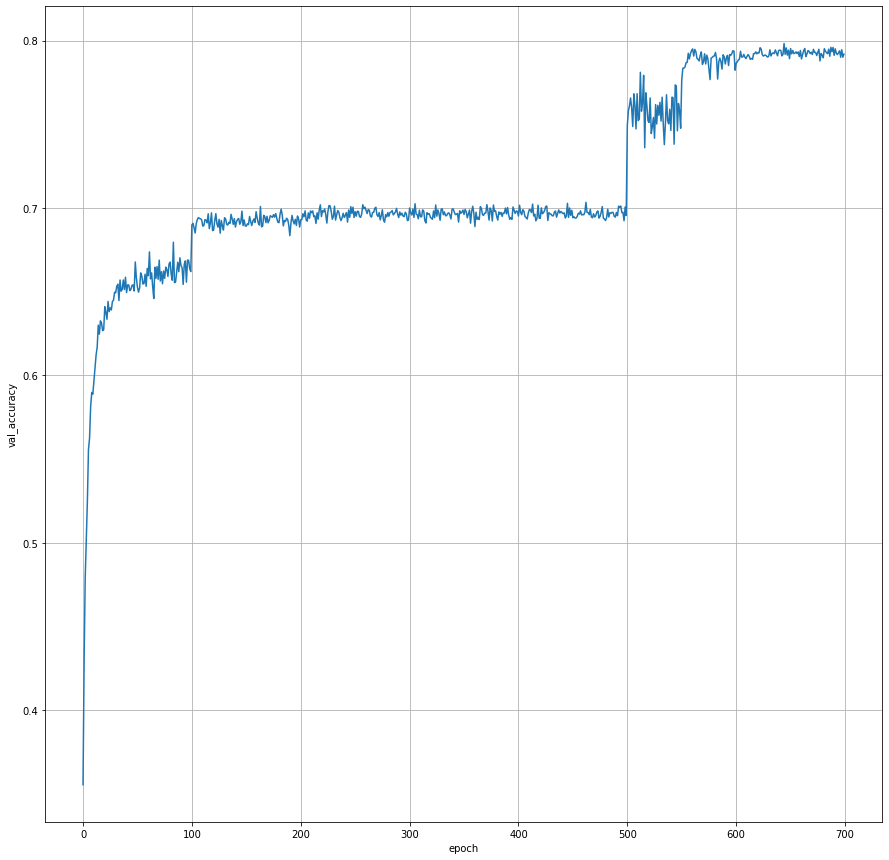

In [18]:
plt.figure(figsize=(15,15))
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.plot(val_acc_list)
plt.grid()

In [19]:
# val_acc_list=np.array(val_acc_list)
# np.savetxt("ver_2.0.txt", val_acc_list, delimiter=',')

### Evaluation

In [20]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [21]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [22]:
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                     std=[0.267, 0.256, 0.276])
test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

In [23]:
test_dataset = torchvision.datasets.ImageFolder('./data/test', transform=test_transform)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [25]:
Category = []
for input, _ in test_loader:
    input = input.cuda()
    output = model(input)
    output = torch.argmax(output, dim=1)
    Category = Category + output.tolist()

In [26]:
Id = list(range(0, 8000))
samples = {
   'Id': Id,
   'Category': Category 
}
df = pd.DataFrame(samples, columns=['Id', 'Category'])

df.to_csv('submission_2.0_2.csv', index=False)
print('Done!!')

Done!!
